In [1]:
import matplotlib.pyplot as plt
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
try:
    with open(task_name + '.dataset', 'rb') as f:
        X, display_data, y, feature_names = pickle.load(f)
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    print('loaded saved state')
except FileNotFoundError:
    pass

loaded saved state


# Setup Task

In [2]:
X, y = shap.datasets.adult()
feature_names = np.array(X.columns)
X = X.values
display_data = shap.datasets.adult(display=True)[0].values
with open(task_name + '.dataset', 'wb') as f:
    pickle.dump((X, display_data, y, feature_names), f, pickle.HIGHEST_PROTOCOL)

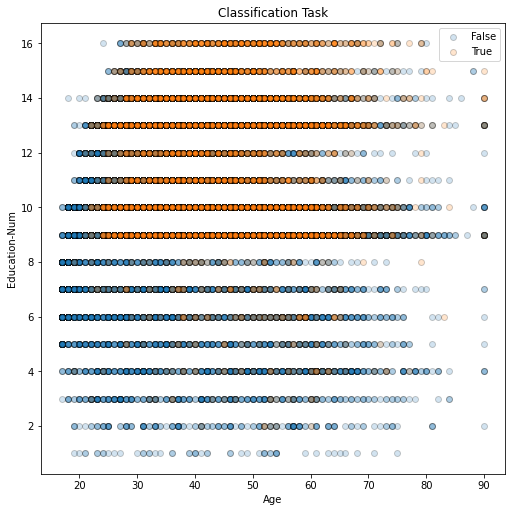

In [4]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Classification Task', feature_names,
                       X_display=display_data, idx_x=0, idx_y=2, fig=fig, ax=ax, alpha=0.2)

We train a simple logistic regression model on the data, and create a "biased" version by preprocessing every input to model B first, where feature Education-Num is increased by 1 in case Age is between 40 and 50 years. This way we get a second classifiers, that behaves exactly like the first, except for a specific range of input values.

In [5]:
%%time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression

class ModifiedClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, base_model):
        self.base_model = base_model
        
    def fit(self, X, y):
        return self
    
    @property
    def classes_(self):
        return self.base_model.classes_
    
    def predict(self, X):
        return self.base_model.predict(self._preprocess(X))
    
    def predict_proba(self, X):
        return self.base_model.predict_proba(self._preprocess(X))
    
    def predict_log_proba(self, X):
        return self.base_model.predict_log_proba(self._preprocess(X))
    
    def _preprocess(self, X):
        X2 = X.copy()
        X2[(40 <= X[:, 0]) & (X[:, 0] < 50), 2] += 1
        return X2
    
clf_a = LogisticRegression(C=1.0, max_iter=10000)
clf_a.fit(X, y)
clf_b = ModifiedClassifier(clf_a)
clf_b.fit(X, y)
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 14.8 s, sys: 1.1 s, total: 15.9 s
Wall time: 8.02 s


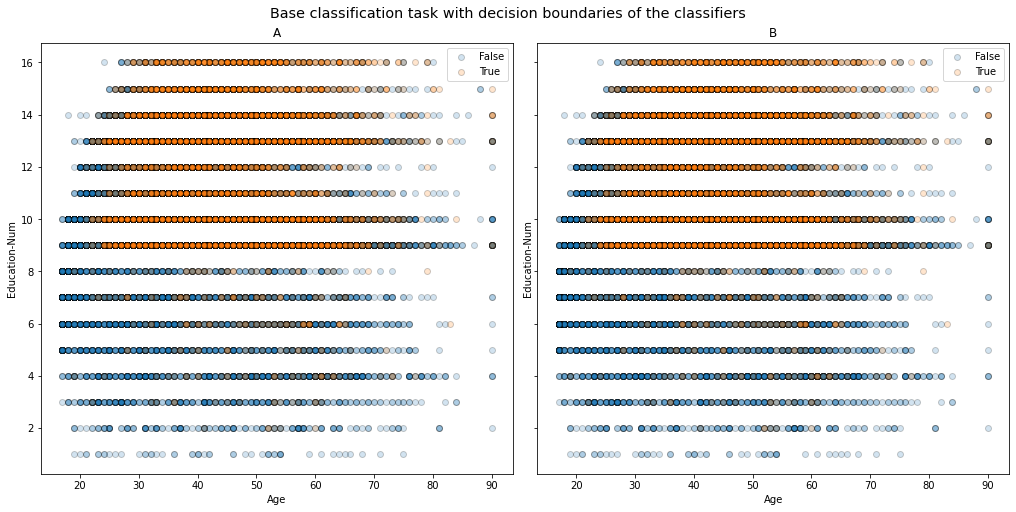

In [6]:
comparer.plot_individual_clf_decision_boundaries(X, display_data, y, kind='label', idx_x=0, idx_y=2, alpha=0.2)

We can see that it predicts different labels in the modified age group for Education-Num 6 and higher.

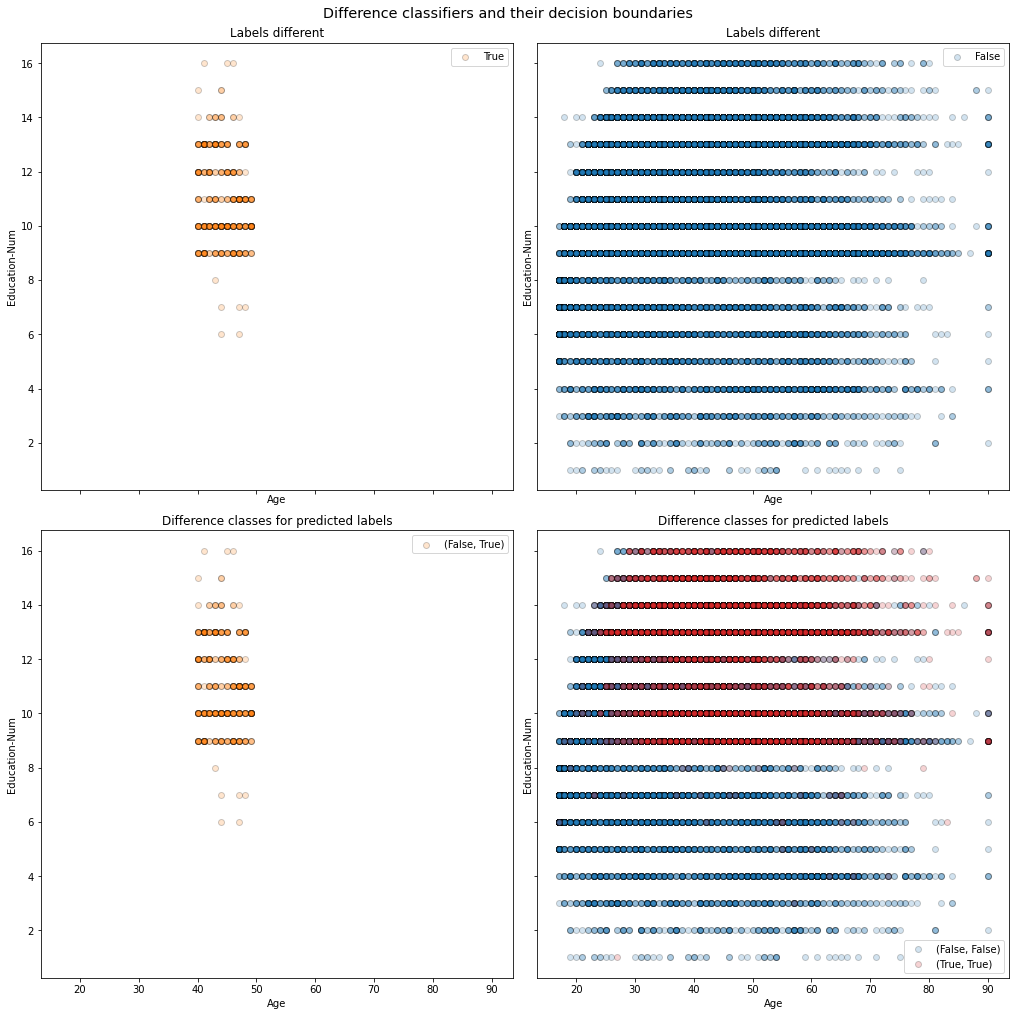

In [7]:
comparer.plot_decision_boundaries(X, display_data, kind='label', idx_x=0, idx_y=2, separate=True, alpha=0.2)

Only one difference class is present: $(False, True)$

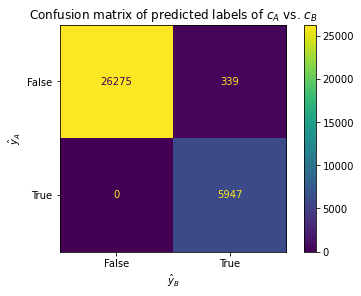

In [8]:
comparer.plot_confusion_matrix(X)